In [1]:
import os
import numpy as np
import astropy.table as aTable
from astropy.io import fits

from galpopfm.catalogs import Catalog

In [2]:
# -- plotting --
import matplotlib as mpl
import matplotlib.pyplot as plt 
import corner as dfm
import matplotlib.patches as mpatches
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read GSWLC data

In [3]:
# read GSWLC data: https://salims.pages.iu.edu/gswlc/#catalog-download
# data column details: https://salims.pages.iu.edu/gswlc/table2.pdf
fgswlc = os.path.join(os.environ['GALPOPFM_DIR'], 'obs', 'GSWLC-M2.dat')
gswlc = np.loadtxt(fgswlc, unpack=True)
#gswlc = np.loadtxt('/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/GSWLC-M2.dat', unpack = True)

In [4]:
T_gswlc = aTable.Table([gswlc[2], gswlc[4], gswlc[3], gswlc[0], gswlc[23], gswlc[9], gswlc[11], gswlc[17], gswlc[13]],
            names=['PLATEID', 'FIBERID', 'MJD', 'PHOTOID', 'SDSSMAIN', 'LOGMSTAR_gswlc', 'LOGSFR_gswlc', 'AV_gswlc', 'A1500_gswlc'])

In [5]:
T_gswlc[:2]

PLATEID,FIBERID,MJD,PHOTOID,SDSSMAIN,LOGMSTAR_gswlc,LOGSFR_gswlc,AV_gswlc,A1500_gswlc
float64,float64,float64,float64,float64,float64,float64,float64,float64
1242.0,461.0,52901.0,1.237645942905635e+18,1.0,11.563,-0.273,0.161,1.593
1242.0,479.0,52901.0,1.237645942905635e+18,1.0,10.763,0.622,0.483,4.695


## read MPA-JHU data

In [6]:
# read MPA-JHU catalog

# dat_dir = '/Users/tjitske/Documents/Projects/QuenchedIsolatedGalaxiesWorkshop/SDSSspectra/'
dat_dir = os.path.join(os.environ['GALPOPFM_DIR'], 'obs')

hdu = fits.open(os.path.join(dat_dir, 'gal_info_dr7_v5_2.fit'))
tab = hdu[1].data

#hdu_class = fits.open(os.path.join(dat_dir, 'gal_iclass_dr7_v5_2.fits'))
#classes = hdu_class[0].data

hdu_indx = fits.open(os.path.join(dat_dir, 'gal_indx_dr7_v5_2.fit'))
tab_indx = hdu_indx[1].data

hdu_totsfr = fits.open(os.path.join(dat_dir, 'gal_totsfr_dr7_v5_2.fits'))
tab_totsfr = hdu_totsfr[1].data

hdu_totlgm = fits.open(os.path.join(dat_dir, 'gal_totlgm_dr7_v5_2b.fit'))
tab_totlgm = hdu_totlgm[1].data

In [7]:
columns = [tab['plateid'], tab['fiberid'], tab['mjd'], tab['photoid'], tab['spectrotype'], tab['Z'], 
           tab_indx['tauv_cont'], tab_indx['tauv_cont'] * 1.086, tab_indx['model_chisq'], tab_totsfr['MEDIAN'], 
          tab_totlgm['MEDIAN']]
names = ['PLATEID', 'FIBERID', 'MJD', 'PHOTOID', 'SPECTROTYPE', 'Z',
        'tauV', 'AV_MPAJHU', 'chisq', 'LOGSFR_mpajhu', 'LOGMSTAR_mpajhu']
T_mpajhu = aTable.Table(columns, names=names)

In [8]:
select = (T_mpajhu['SPECTROTYPE'] == 'GALAXY')
print('number of spectra in catalog: ', len(select), 'number of galaxy spectra: ', np.sum(select))
T_mpajhu = T_mpajhu[select]

number of spectra in catalog:  927552 number of galaxy spectra:  925892


In [9]:
T_mpajhu[:2]

PLATEID,FIBERID,MJD,PHOTOID [5],SPECTROTYPE,Z,tauV,AV_MPAJHU,chisq,LOGSFR_mpajhu,LOGMSTAR_mpajhu
int16,int16,int32,int16,str6,float32,float32,float32,float32,float32,float32
266,1,51602,756 .. 129,GALAXY,0.021275453,0.5578039,0.60577506,1.1943387,-0.46492234,10.294701
266,2,51602,756 .. 235,GALAXY,0.21392463,0.43670884,0.47426578,1.1963152,0.25182927,11.162018


## read NSA/VAGC data

In [10]:
tinker = Catalog('tinker') 

In [11]:
columns = [tinker.data['NSA_PLATE'], tinker.data['NSA_FIBERID'], tinker.data['NSA_MJD'], 
           tinker.data['log.M_star'], tinker.data['log.ssfr'], tinker.data['NSA_AV']]
names = ['PLATEID', 'FIBERID', 'MJD', 'LOGMSTAR_VAGC', 'LOGSSFR_VAGC', 'AV_VAGC']
T_tinker = aTable.Table(columns, names=names)

In [12]:
# select galaxies within observational selection cut
has_spec = T_tinker['PLATEID'] != -999. # limit to ones that have spectra (this is already discrepant with the paper)

sdss_M_fuv, sdss_M_nuv, _, sdss_M_g, sdss_M_r, _, _ = tinker.data['NSA_ABSMAG'].T
sdss_nmgy_fuv, sdss_nmgy_nuv = tinker.data['NSA_NMGY'][:,0], tinker.data['NSA_NMGY'][:,1]

obs_cuts = ((sdss_M_r < -20.) &
        (sdss_M_fuv != -999) & (sdss_M_fuv < -13.5) & 
        (sdss_M_nuv != -999) & (sdss_M_nuv < -14.0) & 
        (sdss_nmgy_fuv > 0) & (sdss_nmgy_nuv > 0)
       ) 

T_tinker = T_tinker[has_spec & obs_cuts]

In [13]:
T_tinker[:2]

PLATEID,FIBERID,MJD,LOGMSTAR_VAGC,LOGSSFR_VAGC,AV_VAGC
float64,float64,float64,float64,float64,float64
409.0,411.0,51871.0,10.854525733159184,-11.29768,0.0
409.0,540.0,51871.0,11.028956473417932,-12.13293,0.6424298286437988


In [14]:
len(T_gswlc), len(T_mpajhu), len(T_tinker)

(361328, 925892, 4451)

## joint catalogs: galaxies in VAGC, MPA-JHU, and GSWLC

In [15]:
T_tinker_gswlc = aTable.join(T_tinker, T_gswlc, keys=['PLATEID', 'FIBERID', 'MJD'], join_type='inner')
print(len(T_tinker_gswlc))
T_tinker_gswlc[:2]

2361


PLATEID,FIBERID,MJD,LOGMSTAR_VAGC,LOGSSFR_VAGC,AV_VAGC,PHOTOID,SDSSMAIN,LOGMSTAR_gswlc,LOGSFR_gswlc,AV_gswlc,A1500_gswlc
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
266.0,430.0,51630.0,10.351506245074157,-10.53325,1.9731956720352173,1.2376487217526213e+18,1.0,10.755,0.11,0.721,2.29
266.0,525.0,51630.0,10.475675614038623,-11.59714,0.08899283409118652,1.237651752385053e+18,1.0,10.726,-2.098,0.09,0.766


In [16]:
T_tinker_mpajhu = aTable.join(T_tinker, T_mpajhu, keys=['PLATEID', 'FIBERID', 'MJD'], join_type='inner')
print(len(T_tinker_mpajhu))
T_tinker_mpajhu[:2]

4245


PLATEID,FIBERID,MJD,LOGMSTAR_VAGC,LOGSSFR_VAGC,AV_VAGC,PHOTOID [5],SPECTROTYPE,Z,tauV,AV_MPAJHU,chisq,LOGSFR_mpajhu,LOGMSTAR_mpajhu
float64,float64,float64,float64,float64,float64,int16,str6,float32,float32,float32,float32,float32,float32
266.0,430.0,51630.0,10.351506245074157,-10.53325,1.9731956720352173,756 .. 142,GALAXY,0.025249595,1.1209217,1.2173209,1.2139626,0.0652922,10.640844
266.0,525.0,51630.0,10.475675614038623,-11.59714,0.08899283409118652,752 .. 68,GALAXY,0.026808288,0.22933322,0.24905588,1.4998804,-1.462914,10.726364


In [17]:
T_alljoint = aTable.join(T_tinker_mpajhu, T_gswlc, keys=['PLATEID', 'FIBERID', 'MJD'], join_type='inner')
print('%i galaxies are in all three catalogs' % len(T_alljoint))

2356 galaxies are in all three catalogs


(-13.0, -9.0)

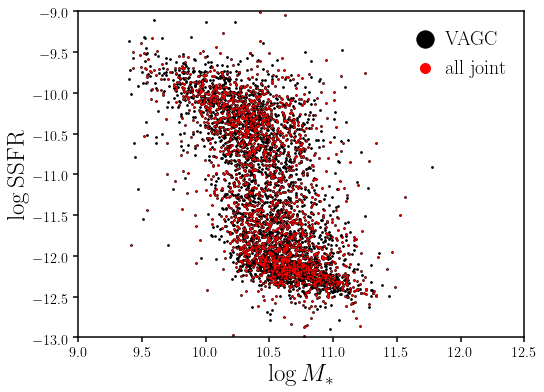

In [18]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(T_tinker['LOGMSTAR_VAGC'], T_tinker['LOGSSFR_VAGC'], c='k', s=3, label='VAGC')
#sub.scatter(T_tinker_mpajhu['LOGMSTAR_VAGC'], T_tinker_mpajhu['LOGSSFR_VAGC'], c='C0', s=2, label='VAGC + MPAJHU')
#sub.scatter(T_tinker_gswlc['LOGMSTAR_VAGC'], T_tinker_gswlc['LOGSSFR_VAGC'], c='C1', s=1, label='VAGC + GSWLC')
sub.scatter(T_alljoint['LOGMSTAR_VAGC'], T_alljoint['LOGSSFR_VAGC'], c='r', s=1, label='all joint')
sub.legend(loc='upper right', markerscale=10, handletextpad=0., fontsize=20)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9., 12.5)
sub.set_ylabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_ylim(-13., -9)

## $A_V$ distribution of star-forming galaxies that pass selection cut

(-13.0, -9.0)

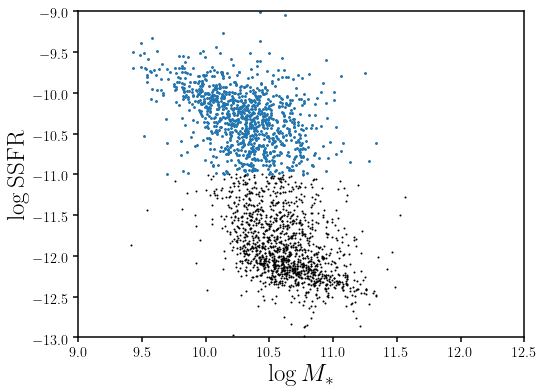

In [19]:
# star-forming galaxies that pass
is_massive_SF = (T_alljoint['LOGSSFR_VAGC'] > -11.)

fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(T_alljoint['LOGMSTAR_VAGC'], T_alljoint['LOGSSFR_VAGC'], c='k', s=1)
sub.scatter(T_alljoint['LOGMSTAR_VAGC'][is_massive_SF], T_alljoint['LOGSSFR_VAGC'][is_massive_SF], c='C0', s=3)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9., 12.5)
sub.set_ylabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_ylim(-13., -9)

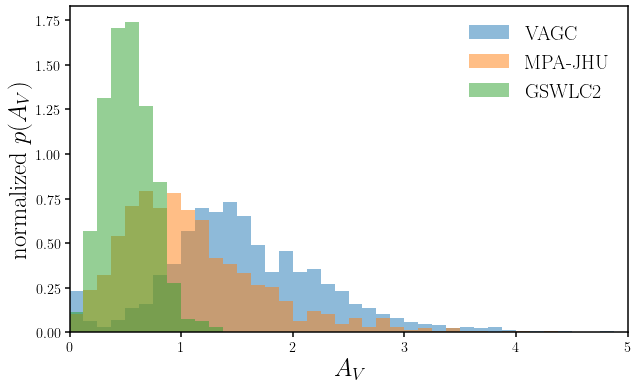

In [20]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
_ = sub.hist(T_alljoint['AV_VAGC'][is_massive_SF], density=True, histtype='stepfilled', alpha=0.5, range=(0.,5), bins=40, label='VAGC')
_ = sub.hist(T_alljoint['AV_MPAJHU'][is_massive_SF], density=True, histtype='stepfilled', alpha=0.5, range=(0.,5), bins=40, label='MPA-JHU')
_ = sub.hist(T_alljoint['AV_gswlc'][is_massive_SF], density=True, histtype='stepfilled', alpha=0.5, range=(0.,5), bins=40, label='GSWLC2')

sub.set_xlabel('$A_V$', fontsize=25)
sub.set_xlim(0., 5.)
sub.set_ylabel('normalized $p(A_V)$', fontsize=25)
sub.legend(loc='upper right', fontsize=20)

# Lets examine $A_V(M_*, {\rm SSFR})$

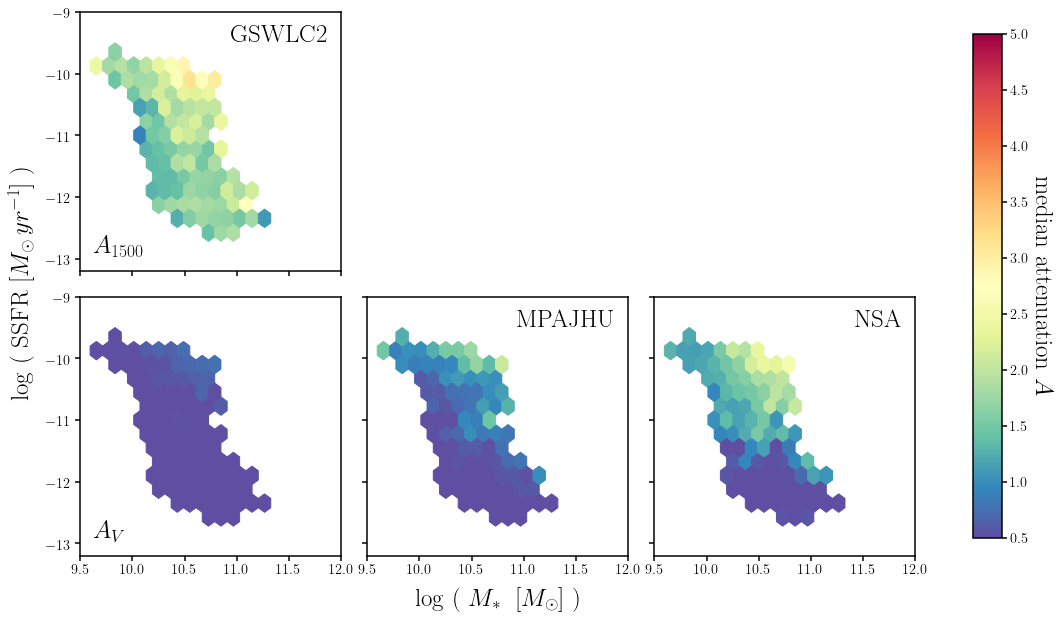

In [28]:
logm = T_alljoint['LOGMSTAR_VAGC']
logssfr = T_alljoint['LOGSSFR_VAGC']
mincnt = 5

fig = plt.figure(figsize=(16, 10))
sub = fig.add_subplot(231)
sub.hexbin(logm, logssfr, C=T_alljoint['A1500_gswlc'], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=5, cmap='Spectral_r')
sub.text(0.05, 0.05, r'$A_{1500}$', 
        ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
sub.text(0.95, 0.95, r'GSWLC2', 
        ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_xticklabels([])
sub.set_ylim([-13.2, -9.])

sub = fig.add_subplot(234)
sub.hexbin(logm, logssfr, C=T_alljoint['AV_gswlc'], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=5, cmap='Spectral_r')
sub.text(0.05, 0.05, r'$A_V$', 
        ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_ylim([-13.2, -9.])

sub = fig.add_subplot(235)
sub.hexbin(logm, logssfr, C=T_alljoint['AV_MPAJHU'], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=5, cmap='Spectral_r')
sub.text(0.95, 0.95, r'MPAJHU', 
        ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_ylim([-13.2, -9.])
sub.set_yticklabels([])

sub = fig.add_subplot(236)
scs = sub.hexbin(logm, logssfr, C=T_alljoint['AV_VAGC'], reduce_C_function=np.median, gridsize=18, 
           vmin=0.5, vmax=5., mincnt=5, cmap='Spectral_r')
sub.text(0.95, 0.95, r'NSA', 
        ha='right', va='top', transform=sub.transAxes, fontsize=25)
sub.set_xlim([9.5, 12.]) 
sub.set_ylim([-13.2, -9.])
sub.set_yticklabels([])

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.85)

cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cbar = fig.colorbar(scs, cax=cbar_ax)
cbar.ax.set_ylabel(r'median attenuation $A$', labelpad=25, fontsize=25, rotation=270)

bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=25) 
bkgd.set_ylabel(r'log ( SSFR $[M_\odot \, yr^{-1}]$ )', labelpad=20, fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.subplots_adjust(wspace=0.1, hspace=0.1)


fig.savefig('../doc/paper/figs/av_mssfr_obs.pdf', bbox_inches='tight')